# Clicks analysis by user rough

In [35]:
import sqlite3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pingouin as pg
from scipy.stats import shapiro
from scipy.stats import probplot
from tabulate import tabulate
from scipy.stats import zscore
from scipy.stats import friedmanchisquare

conn = sqlite3.connect(
    r"C:\Users\max-j\OneDrive\Desktop\Bachelorarbeit_Auswertung\Datenbanken\Auswertung\app_database_2")

queryDataCombinedAvg = """SELECT
                            ClicksDisaggregatedFinal.*,
                            Duration,
                            DurationReached,
                            DurationPrecision,
                            DistanceReached
                          FROM ClicksDisaggregatedFinal
                          RIGHT JOIN TestCaseData
                          ON ClicksDisaggregatedFinal.TestCaseID=TestCaseData.TestCaseID
                            GROUP BY ClicksDisaggregatedFinal.ScenarioCase, ClicksDisaggregatedFinal.TestCaseID;"""

observed_group = 'UserID'
tested_variable = 'ClicksRough'

DataCombinedAvg = pd.read_sql_query(queryDataCombinedAvg, conn)
DataCombinedAvgAggregated = DataCombinedAvg.groupby([observed_group, 'ScenarioCase'])['ClicksRough'].mean().reset_index()

DataCombinedAvgAggregated[f'{tested_variable}_z_within'] = DataCombinedAvgAggregated.groupby('ScenarioCase')[tested_variable].transform(zscore)

for data in DataCombinedAvgAggregated[f'{tested_variable}_z_within']:
    if data >= 2.5 or data <= -2.5:
        print(f"Significant outlier {data}")

Significant outlier 2.662344492882636


               count        mean        std     min       25%      50%  \
ScenarioCase                                                             
FOLDAR          12.0  237.108333  79.912915  130.65  171.3625  231.925   
FOLDAROPEN      12.0  258.395833  61.387897  155.65  221.0750  256.200   
STATEOFTHEART   12.0  365.045833  66.772897  273.75  330.5750  342.400   

                    75%     max  
ScenarioCase                     
FOLDAR         312.6625  370.80  
FOLDAROPEN     285.6875  360.50  
STATEOFTHEART  383.5500  535.25  


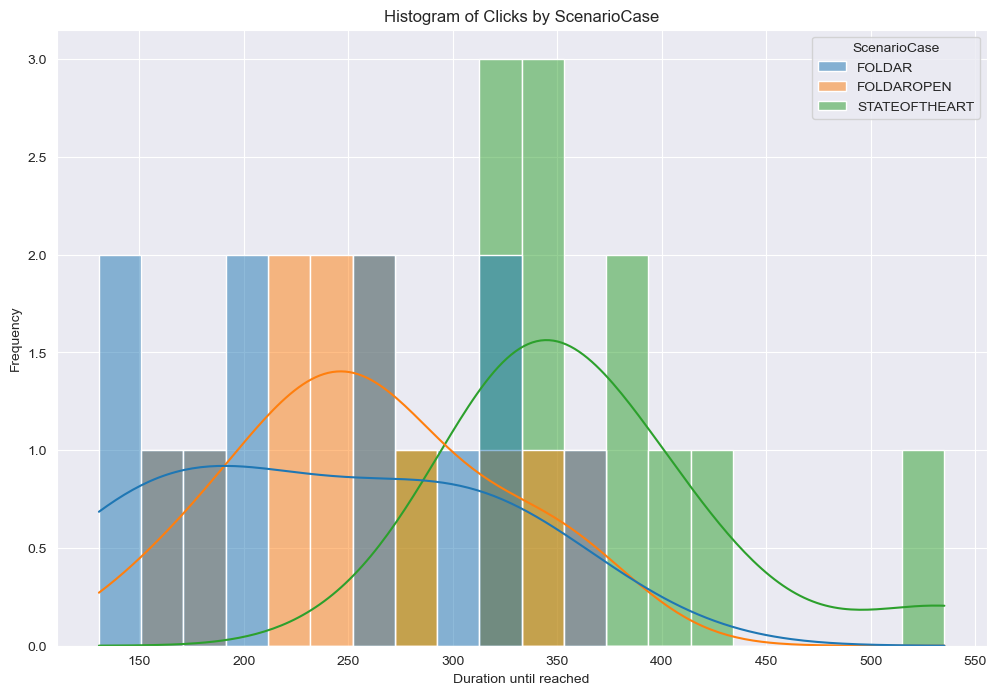

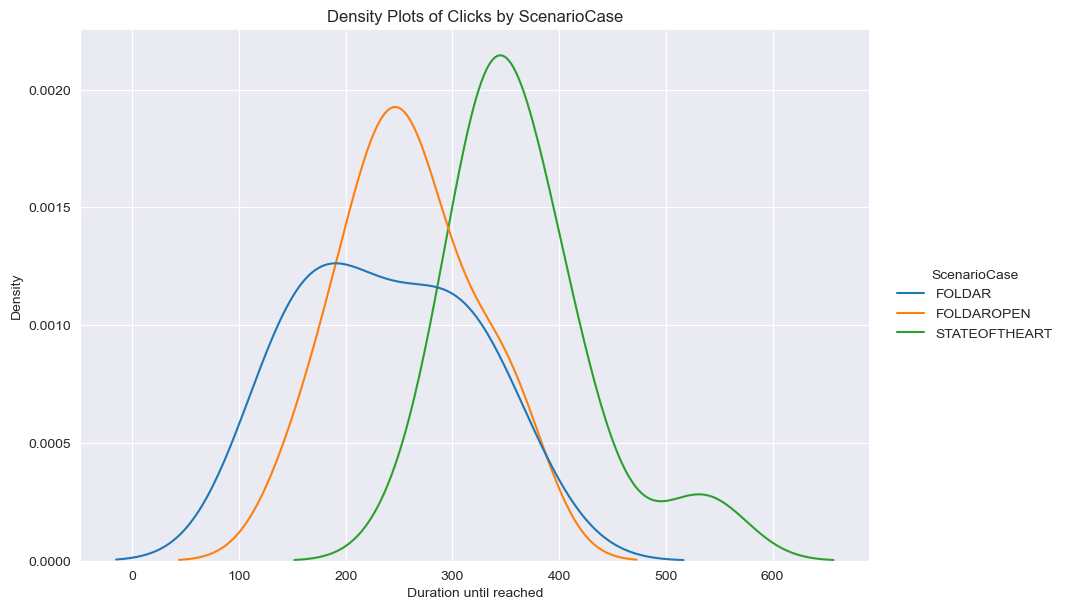

In [36]:
#Average duration for each scenario
summary_stats = DataCombinedAvgAggregated.groupby('ScenarioCase')[tested_variable].describe()
DataUserScenario = DataCombinedAvgAggregated.groupby('ScenarioCase')[["ClicksRough"]].mean().reset_index()
# Falls summary_stats den Index "ScenarioCase" hat,
# setze bei DataUserScenario "ScenarioCase" als Schlüssel.
combined_output = pd.merge(
    summary_stats.reset_index(),  # falls summary_stats als Index ScenarioCase hat
    DataUserScenario,
    on='ScenarioCase',
    how='outer'
)
print(summary_stats)

plt.figure(figsize=(12, 8))
sns.histplot(data=DataCombinedAvgAggregated, x=tested_variable, hue="ScenarioCase", kde=True, bins=20, alpha=0.5)
plt.title('Histogram of Clicks by ScenarioCase')
plt.xlabel("Duration until reached")
plt.ylabel("Frequency")
plt.show()

sns.displot(data=DataCombinedAvgAggregated, x=tested_variable, hue='ScenarioCase', kind="kde", height=6, aspect=1.5)
plt.title("Density Plots of Clicks by ScenarioCase")
plt.xlabel("Duration until reached")
plt.ylabel("Density")
plt.show()

# Check for normality

Shapiro-Wilk Normality Test Results per ScenarioCase:
Scenario: FOLDAR          | Shapiro-Wilk Statistic: 0.937388 | p-value: 0.464999
Scenario: FOLDAROPEN      | Shapiro-Wilk Statistic: 0.973489 | p-value: 0.943698
Scenario: STATEOFTHEART   | Shapiro-Wilk Statistic: 0.871994 | p-value: 0.069272


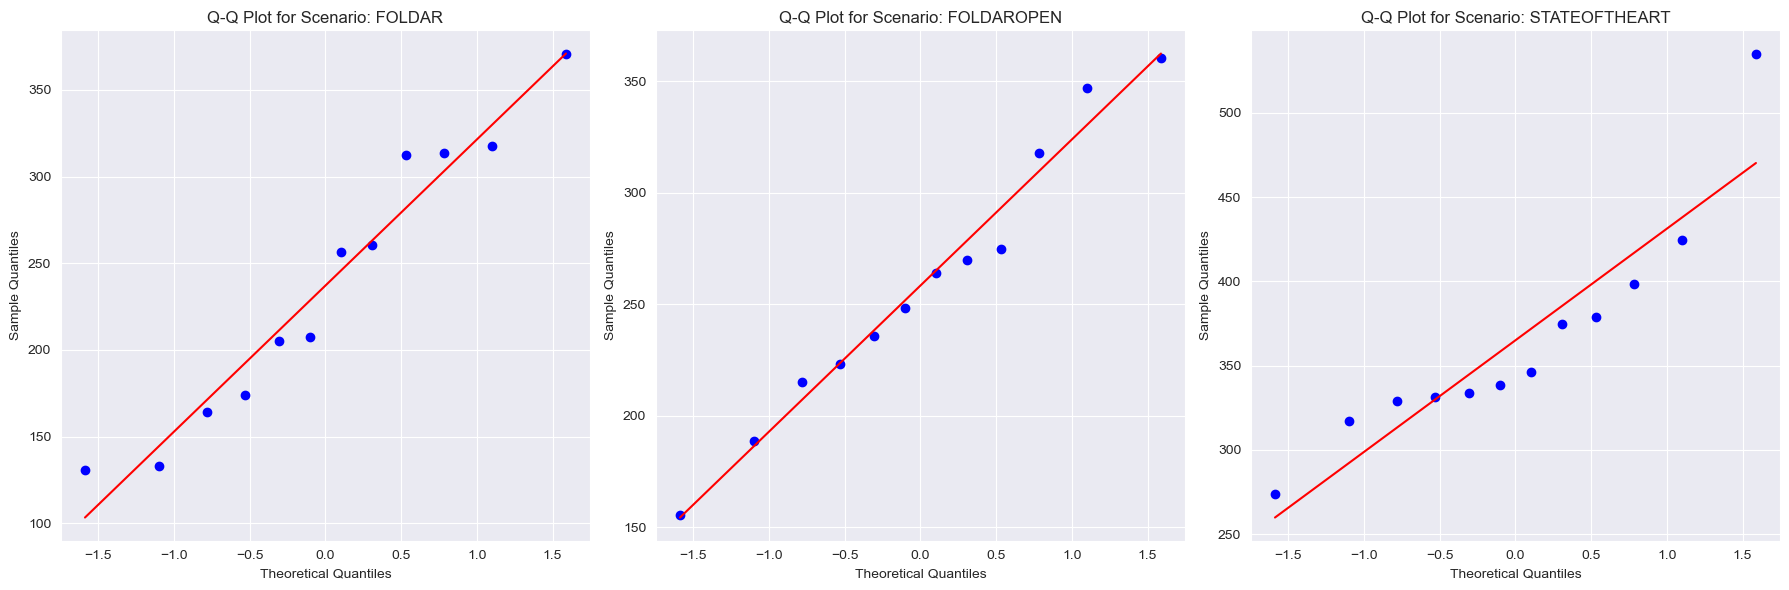

In [37]:
print("Shapiro-Wilk Normality Test Results per ScenarioCase:")
for scenario in DataCombinedAvgAggregated['ScenarioCase'].unique():
    data_scenario = DataCombinedAvgAggregated.loc[DataCombinedAvgAggregated['ScenarioCase'] == scenario, tested_variable]
    stat, p_value = shapiro(data_scenario)
    print(f"Scenario: {scenario:<15} | Shapiro-Wilk Statistic: {stat:.6f} | p-value: {p_value:.6f}")

# Get unique scenarios
scenarios = DataCombinedAvgAggregated['ScenarioCase'].unique()
n_scenarios = len(scenarios)

# Create a subplot grid. For example, one row with n_scenarios columns:
fig, axs = plt.subplots(1, n_scenarios, figsize=(6 * n_scenarios, 6))

# In case there's only one scenario, wrap the ax in a list
if n_scenarios == 1:
    axs = [axs]

# Loop over each scenario and respective subplot axis
for ax, scenario in zip(axs, scenarios):
    data_to_plot = DataCombinedAvgAggregated.loc[DataCombinedAvgAggregated['ScenarioCase'] == scenario, tested_variable]
    probplot(data_to_plot, dist="norm", plot=ax)
    ax.set_title(f"Q-Q Plot for Scenario: {scenario}")
    ax.set_xlabel("Theoretical Quantiles")
    ax.set_ylabel("Sample Quantiles")

plt.tight_layout()
plt.show()

# Friedman Test

Friedman Test Statistic: 13.166666666666657
p-value: 0.0013832308322338394
Significant differences exist between the groups (ScenarioCase).


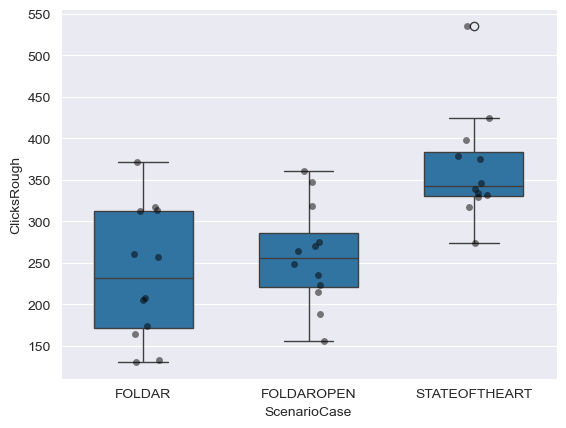

In [38]:
scenario_data = [DataCombinedAvgAggregated[DataCombinedAvgAggregated['ScenarioCase'] == case][tested_variable].values
                 for case in DataCombinedAvgAggregated['ScenarioCase'].unique()]

stat, p_value = friedmanchisquare(*scenario_data)

print(f"Friedman Test Statistic: {stat}")
print(f"p-value: {p_value}")

# Interpretation
if p_value < 0.05:
    print("Significant differences exist between the groups (ScenarioCase).")
else:
    print("No significant differences found.")

sns.boxplot(data=DataCombinedAvgAggregated, x='ScenarioCase', y=tested_variable, width=0.6, showfliers=True)
sns.stripplot(data=DataCombinedAvgAggregated, x='ScenarioCase', y=tested_variable, color='black', alpha=0.5)
plt.show()

# Wilcoxon Test

In [39]:
pairwise_results = pg.pairwise_tests(dv=tested_variable,
                                      within='ScenarioCase',
                                      subject=observed_group,
                                      data=DataCombinedAvgAggregated,
                                      padjust='holm',
                                      parametric= False)

print("\nPairwise Comparisons Table:")
print(tabulate(pairwise_results, headers='keys', tablefmt='psql', showindex=False))


Pairwise Comparisons Table:
+--------------+------------+---------------+----------+--------------+---------+---------------+-------------+------------+------------+-----------+
| Contrast     | A          | B             | Paired   | Parametric   |   W-val | alternative   |       p-unc |     p-corr | p-adjust   |    hedges |
|--------------+------------+---------------+----------+--------------+---------+---------------+-------------+------------+------------+-----------|
| ScenarioCase | FOLDAR     | FOLDAROPEN    | True     | False        |      23 | two-sided     | 0.233398    | 0.233398   | holm       | -0.288449 |
| ScenarioCase | FOLDAR     | STATEOFTHEART | True     | False        |       1 | two-sided     | 0.000976562 | 0.00292969 | holm       | -1.67751  |
| ScenarioCase | FOLDAROPEN | STATEOFTHEART | True     | False        |       2 | two-sided     | 0.00146484  | 0.00292969 | holm       | -1.60551  |
+--------------+------------+---------------+----------+--------------+

# Visualizing the data

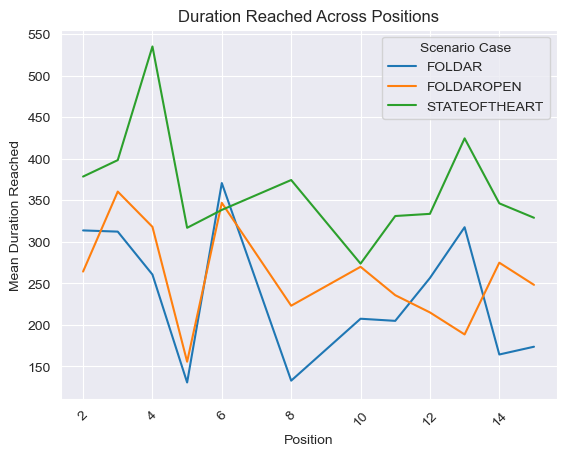

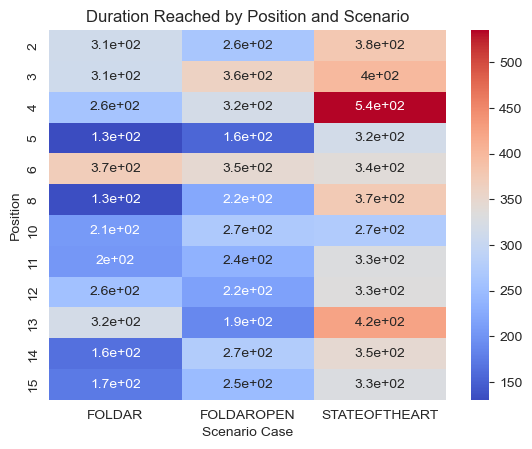

In [40]:
for scenario in DataCombinedAvg['ScenarioCase'].unique():
    scenario_data = DataCombinedAvg[DataCombinedAvg['ScenarioCase'] == scenario]
    means = scenario_data.groupby(observed_group)[tested_variable].mean()
    plt.plot(means.index, means.values, label=scenario)

plt.title("Duration Reached Across Positions")
plt.xlabel("Position")
plt.ylabel("Mean Duration Reached")
plt.legend(title="Scenario Case")
plt.xticks(rotation=45)
plt.show()


pivot_data = DataCombinedAvg.pivot_table(index=observed_group, columns='ScenarioCase', values=tested_variable,
                                         aggfunc='mean')
sns.heatmap(pivot_data, annot=True, cmap='coolwarm')
plt.title("Duration Reached by Position and Scenario")
plt.xlabel("Scenario Case")
plt.ylabel("Position")
plt.show()